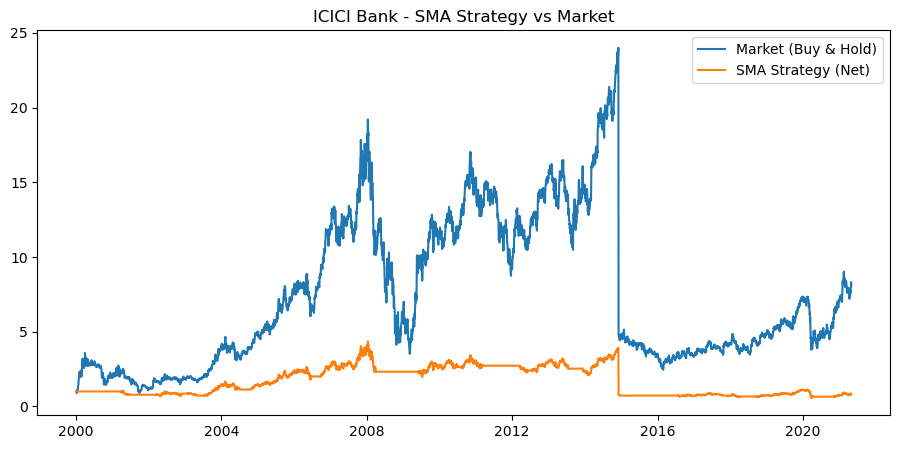

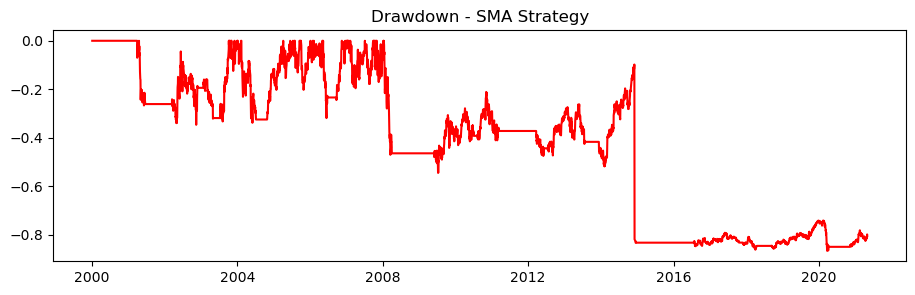

{'CAGR': np.float64(-0.81), 'Sharpe': np.float64(0.21), 'Max Drawdown': -86.65, 'Win Rate': np.float64(30.4), 'Total Return': np.float64(-15.73)}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Step 1: Load your CSV
path = r"C:\Users\sahil\Downloads\ICICIBANK.csv"   # <-- your file path
df = pd.read_csv(path)

# 🔹 Step 2: Normalize columns
# Adjust column names depending on Kaggle dataset format
df.rename(columns={
    "Date": "Date",
    "Close": "Close Price",  # some datasets use "Close Price" instead of "Close"
}, inplace=True)

# If your file already has "Close" column, just set:
# df.rename(columns={"Close": "Close"}, inplace=True)

# 🔹 Step 3: Parse Date & sort
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date")
df = df.reset_index(drop=True)

# 🔹 Step 4: Use Close price for strategy
if "Close" in df.columns:
    df["Close"] = df["Close"]
elif "Close Price" in df.columns:
    df["Close"] = df["Close Price"]
else:
    raise ValueError(f"No Close column found! Columns: {list(df.columns)}")

# 🔹 Step 5: Calculate SMA indicators
fast, slow = 50, 200
df["SMA_fast"] = df["Close"].rolling(fast).mean()
df["SMA_slow"] = df["Close"].rolling(slow).mean()

# 🔹 Step 6: Generate signals
df["Signal"] = np.where(df["SMA_fast"] > df["SMA_slow"], 1, 0)
df["Position"] = df["Signal"].shift(1).fillna(0)

# 🔹 Step 7: Backtest
df["Return"] = df["Close"].pct_change().fillna(0.0)
df["StratGross"] = df["Position"] * df["Return"]

# Add transaction costs (0.1% = 10 bps)
df["Trade"] = df["Position"].diff().abs().fillna(0.0)
cost = 0.001
df["Cost"] = df["Trade"] * cost
df["StratNet"] = df["StratGross"] - df["Cost"]

# Equity curves
df["Equity_Market"] = (1 + df["Return"]).cumprod()
df["Equity_Strat"]  = (1 + df["StratNet"]).cumprod()

# 🔹 Step 8: Plot equity curves
plt.figure(figsize=(11,5))
plt.plot(df["Date"], df["Equity_Market"], label="Market (Buy & Hold)")
plt.plot(df["Date"], df["Equity_Strat"], label="SMA Strategy (Net)")
plt.title("ICICI Bank - SMA Strategy vs Market")
plt.legend()
plt.show()

# 🔹 Step 9: Drawdown plot
roll_max = df["Equity_Strat"].cummax()
df["Drawdown"] = df["Equity_Strat"]/roll_max - 1.0

plt.figure(figsize=(11,3))
plt.plot(df["Date"], df["Drawdown"], color="red")
plt.title("Drawdown - SMA Strategy")
plt.show()

# 🔹 Step 10: Performance metrics
def performance_metrics(df, periods_per_year=252):
    total_ret = df["Equity_Strat"].iloc[-1] - 1
    n_years = len(df) / periods_per_year
    cagr = (1 + total_ret)**(1/n_years) - 1

    rets = df["StratNet"].dropna()
    sharpe = (rets.mean() / rets.std()) * np.sqrt(periods_per_year)
    max_dd = df["Drawdown"].min()
    win_rate = (rets > 0).mean()

    return {
        "CAGR": round(cagr*100, 2),
        "Sharpe": round(sharpe, 2),
        "Max Drawdown": round(max_dd*100, 2),
        "Win Rate": round(win_rate*100, 2),
        "Total Return": round(total_ret*100, 2)
    }

metrics = performance_metrics(df)
print(metrics)
